In [1]:
import sys
import numpy
import matplotlib
import skimage
import tensorflow as tf
import cv2
from skimage.transform import resize, rescale
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage import measure
#import measure.compare_ssim as ssim
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [2]:
def train_high(path, size, scale):
    names = sorted(os.listdir(path))
    print(len(names))
    data = []
    for name in names:
        fpath = os.path.join(path, name)
        img = cv2.imread(fpath)
        img = cv2.resize(img, (size,size), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255   # y is the luma.
        shape = img.shape
        data.append(img) # no. of images  #900 ---->(w,h)
    data = np.array(data)   # (no. of image, w, h)
    return data

In [3]:
def train_low(path,size,scale):
    names = sorted(os.listdir(path)) # get  all items  in path
    print(len(names)) # print no. of img
    data = []
    for name in names:
        fpath = os.path.join(path, name)  # add name  of img to the path
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size),cv2.INTER_CUBIC)  # downsample bicubic
        img = cv2.resize(img, ((size*scale),(size*scale)),cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255   # y is the luma
        shape = img.shape
        data.append(img)
    data = np.array(data)
    return data

In [4]:
def model():

    # define model type
    SRCNN = Sequential()

    # add model layers  #    (1392, 2040, 3)
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True, input_shape=(None,None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True))

    # define optimizer
    adam = Adam(lr=0.0003)
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])

    return SRCNN

In [5]:
srcnn = model()
srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   10496     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85889 (335.50 KB)
Trainable params: 85889 (335.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
Xtrain_high = train_high('/content/drive/MyDrive/Master_Thesis/DATASET/train_dataset/DIV2K_DATASET_900_HR', 256, 2)

900


In [7]:
Xtrain_high.shape

(900, 256, 256)

In [8]:
y_train_low = train_low('/content/drive/MyDrive/Master_Thesis/DATASET/train_dataset/DIV2K_DATASET_900_HR',64,4)

900


In [9]:
y_train_low.shape

(900, 256, 256)

Text(0.5, 1.0, 'high resolution ')

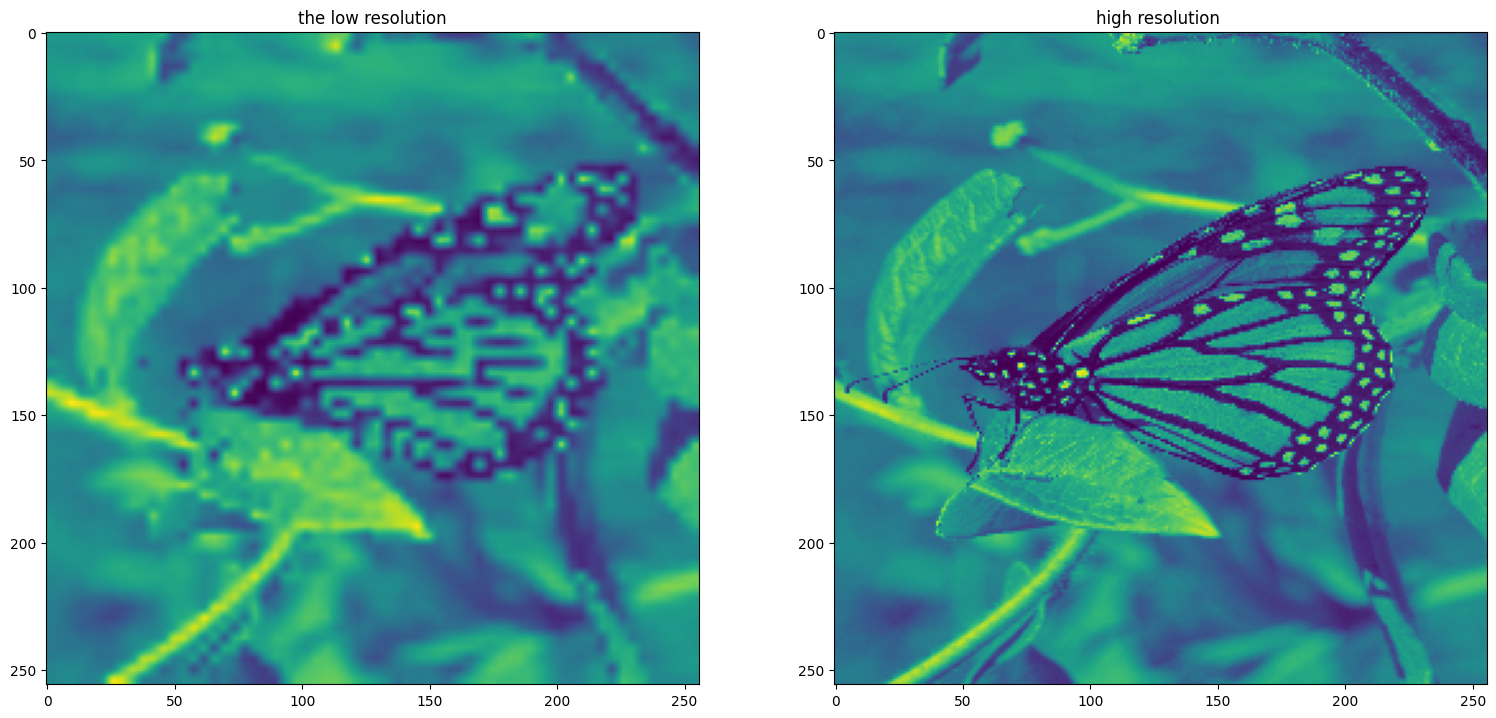

In [10]:
plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(y_train_low[5])
plt.title("the low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(Xtrain_high[5])
plt.title("high resolution ")

In [11]:
low= numpy.zeros((y_train_low.shape[0], y_train_low.shape[1], y_train_low.shape[2], 1), dtype=float)
low[:, :, :, 0]=y_train_low[:, :, :].astype(float)
low.shape

(900, 256, 256, 1)

In [12]:
high= numpy.zeros((Xtrain_high.shape[0], Xtrain_high.shape[1], Xtrain_high.shape[2], 1), dtype=float)
high[:, :, :, 0]=Xtrain_high[:, :, :].astype(float)
high.shape

(900, 256, 256, 1)

In [13]:
# Define the ModelCheckpoint callback to save weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'srcnn_weights_best.h5',
    monitor='val_loss',  # You can monitor any metric you want
    save_best_only=True,  # Save only the best model based on the monitored metric
    mode='min',  # 'min' or 'max' depending on whether you want to minimize or maximize the monitored metric
    verbose=1  # Print messages when saving the best model
)


In [14]:
# Define the EarlyStopping callback as you already have
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [15]:
history = srcnn.fit(low, high, batch_size=10, validation_split=0.2, shuffle=True, epochs=100,
                    callbacks=[checkpoint_callback, early_stopping_callback])


last_epoch = len(history.history['loss'])
print(f"Training finished at epoch {last_epoch}")

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.0123
Epoch 1: val_loss improved from inf to 0.01516, saving model to srcnn_weights_best.h5
72/72 [==============================] - 24s 111ms/step - loss: 0.0251 - accuracy: 0.0123 - val_loss: 0.0152 - val_accuracy: 0.0101
Epoch 2/100
 1/72 [..............................] - ETA: 5s - loss: 0.0097 - accuracy: 4.8370e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.0125
Epoch 2: val_loss improved from 0.01516 to 0.01434, saving model to srcnn_weights_best.h5
72/72 [==============================] - 7s 100ms/step - loss: 0.0152 - accuracy: 0.0125 - val_loss: 0.0143 - val_accuracy: 0.0101
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.0125
Epoch 3: val_loss improved from 0.01434 to 0.01422, saving model to srcnn_weights_best.h5
72/72 [==============================] - 7s 101ms/step - loss: 0.0150 - accuracy: 0.0125 - val_loss: 0.0142 - val_accuracy: 0.0101
Epoch 4/100
72/72 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.0125
Epoch 4: val_loss improved from 0.01422 to 0.01422, saving model to srcnn_weights_best.h5
72/72 [==============================] - 7s 103ms/step - loss: 0.0148 - accuracy: 0.0125 - val_loss: 0.0142 - val_accuracy: 0.0101
Epoch 5/100
72/72 [==============================] - ETA: 0s - l

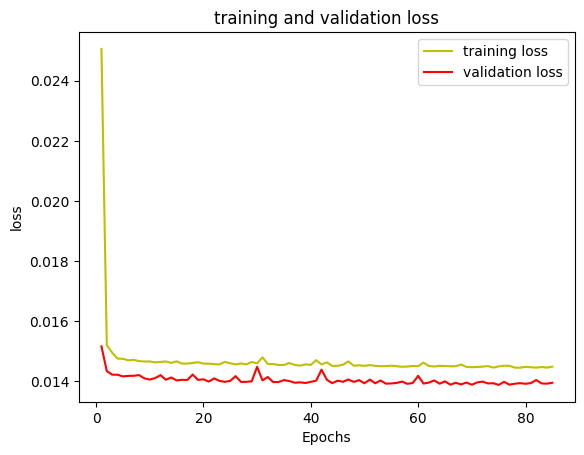

In [16]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Master_Thesis/SRCNN/Results/x4/training_and_validation_loss{last_epoch}.png")
plt.show()

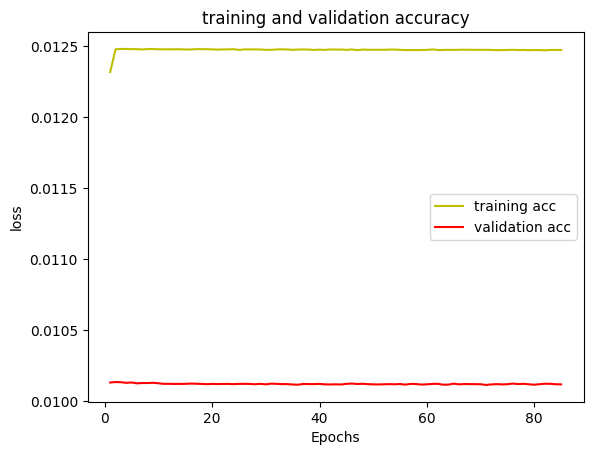

In [17]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Master_Thesis/SRCNN/Results/x4/training_and_validation_accuracy{last_epoch}.png")
plt.show()

In [19]:
srcnn.save('/content/drive/MyDrive/Colab Notebooks/Master_Thesis/SRCNN/SRCNNx4/srcnn_4x.h5')